In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN, MeanShift, estimate_bandwidth, KMeans, OPTICS, cluster_optics_dbscan, AffinityPropagation
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.drop(['id'], axis=1,inplace=True)
df.info()
# df['stroke']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [3]:
df['gender']=df['gender'].apply(lambda x : 1 if x=='Male' else 0) 
df["ever_married"] = df["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
df["Residence_type"] = df["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)

df = pd.get_dummies(data=df, columns=['smoking_status'])
df = pd.get_dummies(data=df, columns=['work_type'])

X = df.drop(['stroke'], axis=1).values
imputer = SimpleImputer()
X = imputer.fit_transform(X)

y = df['stroke'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

smote = SMOTE()

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)

# df['stroke'].value_counts()


In [4]:
df1 = pd.DataFrame(X)
# statistical analysis of bmi
print(round(df1.iloc[:,7].describe(),2))

count    5110.00
mean       28.89
std         7.70
min        10.30
25%        23.80
50%        28.40
75%        32.80
max        97.60
Name: 7, dtype: float64


In [5]:
# imputer = SimpleImputer()
x = df.iloc[:,[1,6,7,8]]
x = imputer.fit_transform(x)
x = np.array(x)
x

array([[ 67.        , 228.69      ,  36.6       ,   1.        ],
       [ 61.        , 202.21      ,  28.89323691,   1.        ],
       [ 80.        , 105.92      ,  32.5       ,   1.        ],
       ...,
       [ 35.        ,  82.99      ,  30.6       ,   0.        ],
       [ 51.        , 166.29      ,  25.6       ,   0.        ],
       [ 44.        ,  85.28      ,  26.2       ,   0.        ]])

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


svm = SVC(kernel='rbf', random_state=0, gamma=0.5, C=1)

svm.fit(X_train_smote,y_train_smote)

y_pred = svm.predict(X_train_smote)

accuracy = metrics.accuracy_score(y_train_smote,y_pred)
# precision = metrics.precision_score(y_train_smote,y_pred)
class_report = metrics.classification_report(y_train_smote,y_pred)

print(accuracy)
# print(precision)
print(class_report)


1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2922
           1       1.00      1.00      1.00      2922

    accuracy                           1.00      5844
   macro avg       1.00      1.00      1.00      5844
weighted avg       1.00      1.00      1.00      5844



1.0
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2922
           1       1.00      1.00      1.00      2922

    accuracy                           1.00      5844
   macro avg       1.00      1.00      1.00      5844
weighted avg       1.00      1.00      1.00      5844



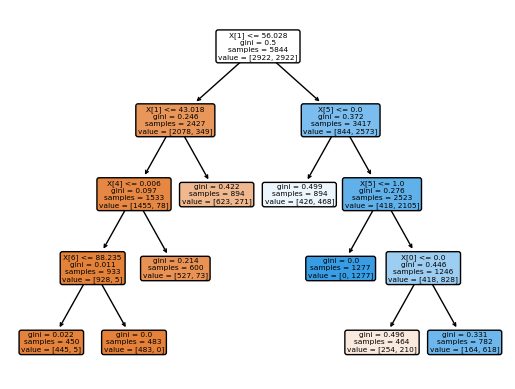

In [7]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(min_samples_leaf=450)
dt = dt.fit(X_train_smote,y_train_smote)

# tree.plot_tree(dt)

dot_data = tree.export_graphviz(dt, out_file=None)
tree.plot_tree(dt, filled=True, rounded=True)

accuracy = metrics.accuracy_score(y_train_smote,y_pred)
precision = metrics.precision_score(y_train_smote,y_pred)
class_report = metrics.classification_report(y_train_smote,y_pred)

print(accuracy)
print(precision)
print(class_report)

In [8]:
x1 = x[:,[0,2,3]]

db = DBSCAN(eps=0.3, min_samples=10).fit(x1)
labels = db.labels_

print(labels)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

silhouette = metrics.silhouette_score(y.reshape(-1,1),labels)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")
print(f'Silhouette Score: {silhouette}')

[-1 -1 -1 ... -1 -1 -1]
Estimated number of clusters: 5
Estimated number of noise points: 5058
Silhouette Score: -0.9387062245779717


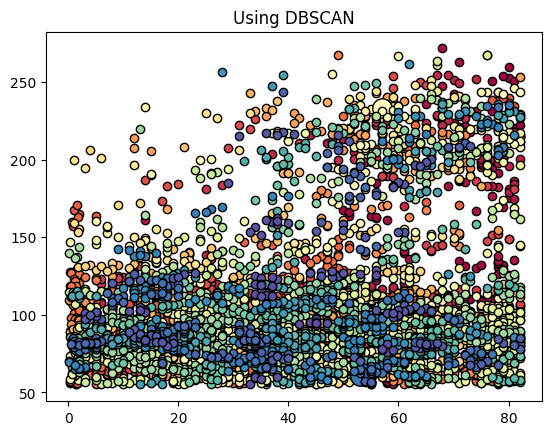

In [20]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = x[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = x[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Using DBSCAN")

plt.show()

In [10]:
bandwidth = estimate_bandwidth(x, quantile=0.2,n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

silhoutte = metrics.silhouette_score(x,labels)
print(f"Number of estimated clusters: {n_clusters_}")
print(silhoutte)

Number of estimated clusters: 2
0.6472244914449011


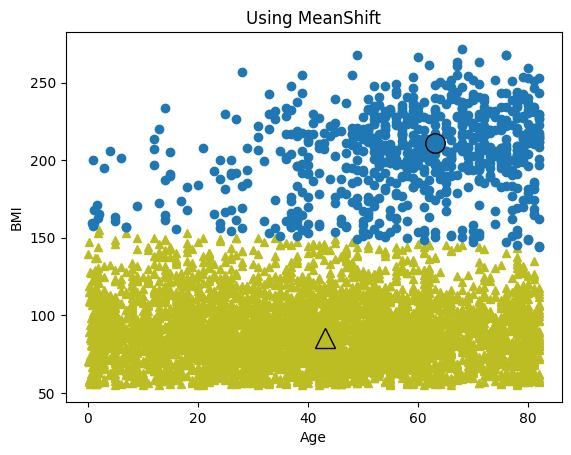

In [11]:
plt.figure(1)
plt.clf()

x1 = x[0,1]

colors = ["tab:olive", "tab:blue"]

markers = ["^", "o"]

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(x[my_members, 0], x[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Using MeanShift")

plt.xlabel("Age")
plt.ylabel('BMI')
plt.show()

In [12]:
km = KMeans(n_clusters=2,
init = 'random', n_init = 5,
max_iter = 100, tol = 0.01)

y_km = km.fit_predict(x)

labels = km.labels_

print(x[y_km == 0,0])

silhoutte = metrics.silhouette_score(x,labels)

print(silhoutte)

[67.   61.   49.   79.   81.   78.   79.   50.   64.   75.   57.   71.
 52.   79.   82.   58.   69.   59.   57.   82.   80.   74.   82.   60.
 76.   63.   63.   78.   73.   54.   56.   70.   67.   63.   80.   51.
 79.   78.   58.   77.   74.   54.   45.   71.   80.   56.   72.   82.
 73.   69.   68.   71.   76.   76.   75.   72.   66.   70.   79.   68.
 77.   57.   71.   78.   56.   72.   81.   82.   61.   65.   68.   59.
 70.   74.   80.   63.   79.   55.   76.   73.   81.   63.   57.   81.
 77.   78.   68.   77.   57.   68.   68.   14.   47.   75.   74.   37.
 71.   54.   70.   58.   67.   69.   66.   43.   51.   78.   48.   76.
 57.   78.   78.   33.   82.   64.   79.   66.   76.   72.   70.   60.
 58.   64.   38.   37.   56.   53.   69.   62.   63.   65.   75.   61.
 43.   38.   61.   54.   74.   28.   16.   42.   77.   76.   52.   39.
 67.   72.   57.   29.   18.   72.    5.   65.   46.   15.   59.   56.
 48.   73.   50.   33.   80.   61.   27.   66.   59.   34.   56.   71.
 31.  

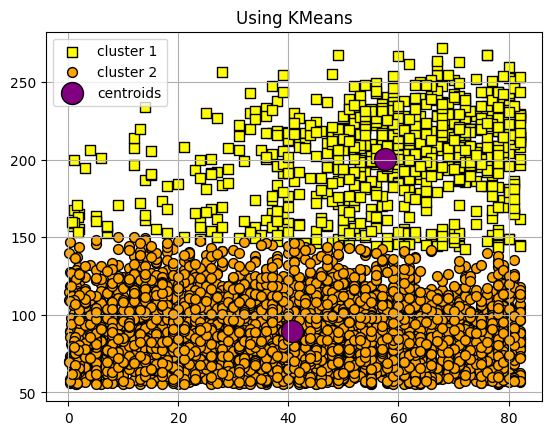

In [13]:
plt.scatter(
    x[y_km == 0,0], x[y_km == 0,1], s=50, c='yellow', marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    x[y_km == 1, 0], x[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    km.cluster_centers_[:,0], km.cluster_centers_[:,1],
    s=250,edgecolors="black", c='purple',
    label='centroids'
)

plt.legend(scatterpoints=1)
plt.title("Using KMeans")
plt.grid()
plt.show()

[0 0 1 ... 1 0 1]
0.11067208078839412


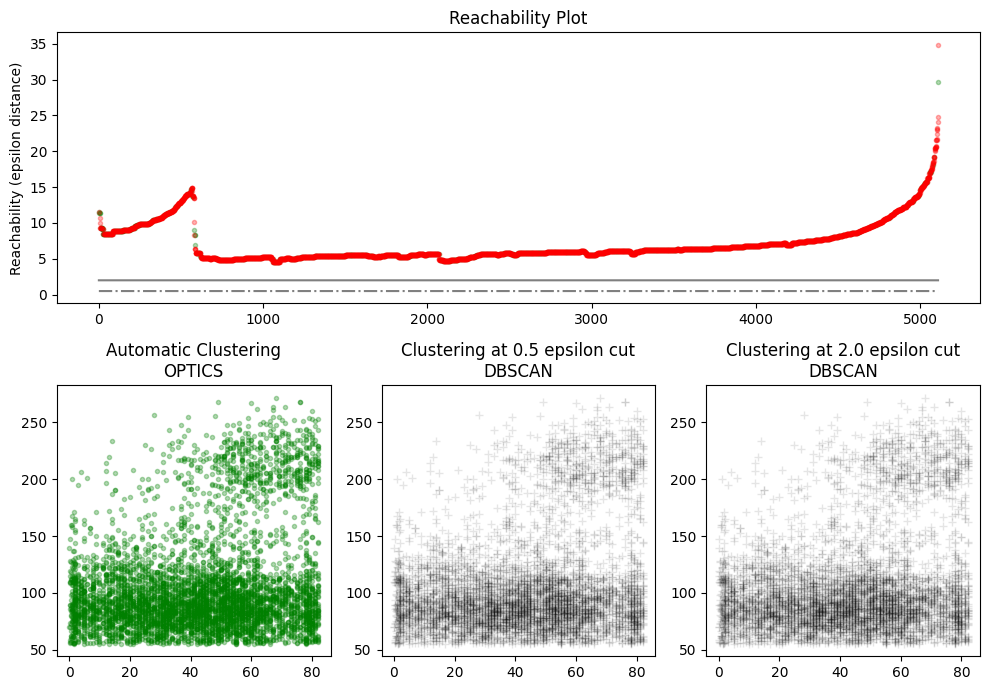

In [14]:
clust = OPTICS(min_samples=50,xi=0.05,min_cluster_size=0.05)

clust.fit(x)


labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(x))
reachability = clust.reachability_[clust.ordering_]
labels1 = clust.labels_[clust.ordering_]
print(labels)


plt.figure(figsize=(10, 7))
G = gs.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = x[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(x[clust.labels_ == -1, 0], x[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g.", "r.", "b.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = x[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(x[labels_050 == -1, 0], x[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = x[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(x[labels_200 == -1, 0], x[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

silhouette = metrics.silhouette_score(X_test_smote, y_test_smote)

print(silhouette)

plt.tight_layout()
plt.show()

C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Estimated number of clusters: 847
Homogeneity: 0.761
Completeness: 0.951
V-measure: 0.846
Adjusted Rand Index: 0.003


C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\edwar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values fo

Adjusted Mutual Information: 0.008
Silhouette Coefficient: 0.379


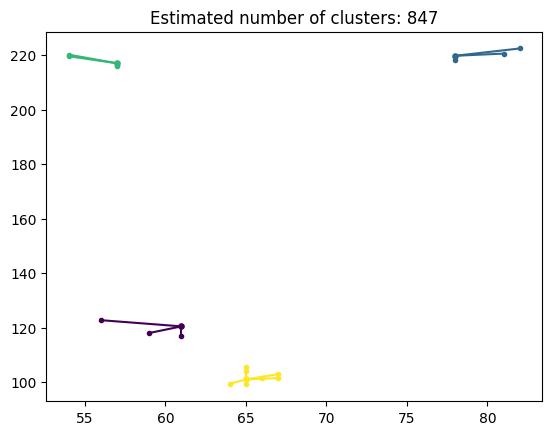

In [15]:
af = AffinityPropagation(preference=-50, random_state=0).fit(x)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

# silhoutte = metrics.silhouette_score(x,labels)
# silhoutte = metrics.silhouette_score(y, labels)

# print(silhoutte)
# print(class_report)

n_clusters_ = len(cluster_centers_indices)

x1 = x[:, 1]

print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(x1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(x1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(x1, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(x1, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(x1, labels)
)
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, labels, metric="sqeuclidean")
)

plt.close("all")
plt.figure(1)
plt.clf()

colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, 4)))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = x[cluster_centers_indices[k]]
    plt.scatter(
        x[class_members, 0], x[class_members, 1], color=col["color"], marker="."
    )
    plt.scatter(
        cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o"
    )
    for i in x[class_members]:
        plt.plot(
            [cluster_center[0], i[0]], [cluster_center[1], i[1]], color=col["color"]
        )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

[0.02929684]
mean absolute error: 5.43
mean squared error: 50.01
root mean squared error: 7.07


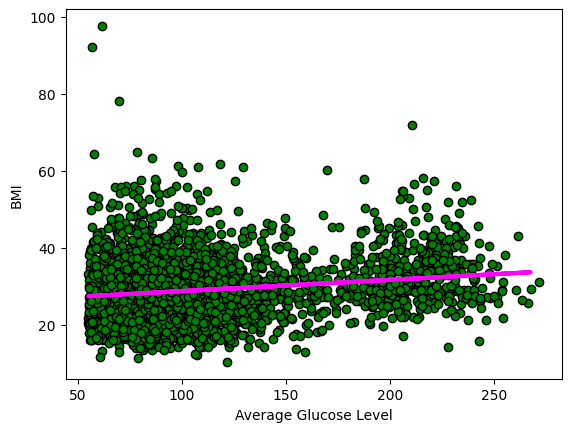

In [16]:
from sklearn.linear_model import LinearRegression

def root_mean_squared_error(actual,prediction):
    return np.sqrt(metrics.mean_squared_error(actual,prediction))

x1 = x[:,1]
x2 = x[:,2]


x1 = x1[:,np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(x1, x2, random_state=0)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.coef_)

y_pred = lr.predict(x_test)

mar = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"mean absolute error: {round(mar,2)}")
print(f"mean squared error: {round(mse,2)}")
print(f"root mean squared error: {round(rmse,2)}")

plt.scatter(x_train, y_train, color='green', edgecolors='black')
plt.plot(x_test, y_pred, color="magenta", linewidth=3)

plt.xticks()
plt.yticks()

plt.xlabel("Average Glucose Level")
plt.ylabel("BMI")

plt.show()


[ 0.         -0.04500421  0.00026287]
mean absolute error: 5.42
mean squared error: 49.68
root mean squared error: 7.05


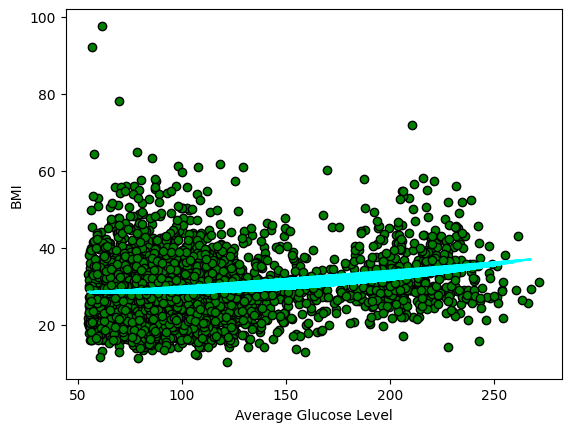

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(x_train)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly,y_train)
print(poly_reg_model.coef_)

y_pred = poly_reg_model.predict(poly_reg.fit_transform(x_test))

mar = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"mean absolute error: {round(mar,2)}")
print(f"mean squared error: {round(mse,2)}")
print(f"root mean squared error: {round(rmse,2)}")

plt.scatter(x_train, y_train,color='green',edgecolors='black')
plt.plot(x_test,y_pred, color='cyan')

plt.xlabel("Average Glucose Level")
plt.ylabel("BMI")

plt.show()

In [18]:
import plotly.graph_objects as go

color_palette = ['#1CC7F9', '#2DE31E', '#F98A1C']

df.drop(['gender','ever_married','Residence_type','smoking_status_Unknown','smoking_status_formerly smoked','smoking_status_never smoked',
        'smoking_status_smokes','work_type_Govt_job','work_type_Never_worked','work_type_Private','work_type_Self-employed','work_type_children'], axis=1, inplace=True)

corr = df.corr()

fig = go.Figure(data= go.Heatmap(z=corr,
                                 x=corr.index.values,
                                 y=corr.columns.values,
                                 colorscale=color_palette,
                                 text = corr.round(2), texttemplate="%{text}", xgap=3, ygap=3
                                 )
                )

fig.update_layout(title_text='<b>Correlation Matrix<b>',
                  title_x=0.5,
                  titlefont={'size': 24, 'family': 'Courier New'},
                  width=900, height=600,
                  xaxis_showgrid=False,
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed', 
                  paper_bgcolor=None,
                  template='seaborn'
                  )

In [19]:
from sklearn.ensemble import RandomForestClassifier
import plotly.figure_factory as ff

rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train_smote, y_train_smote)

#Score 
rfc_score = rfc.score(X_train_smote, y_train_smote)
rfc_test = rfc.score(X_test_smote, y_test_smote)

# Model Testing
y_pred = rfc.predict(X_test_smote)

# Evaluation
rfc_cm = metrics.confusion_matrix(y_test_smote,y_pred)
class_report = metrics.classification_report(y_test_smote,y_pred)
print(f'Training Score: {rfc_score.round(3)}')
print(f'Testing Score: {rfc_test.round(3)}')
print(f'{class_report}')

conf_matrix = pd.DataFrame(data=rfc_cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
# print(f'Accuracy Score: {metrics.accuracy_score(y_test,y_pred).round(3)}')

z=rfc_cm
fig = ff.create_annotated_heatmap(z, x=['Not Stroke','Stroke'], y=['Predicted Not Stroke','Predicted Stroke'], colorscale='Fall',xgap=3,ygap=3)
fig['data'][0]['showscale'] = True

fig.update_layout(title_text='<b>Confusion Matrix for Random Forest Classifier<b>',
                  title_x=0.5,
                  titlefont={'size': 24, 'family': 'Courier New'},
                  width=900, height=400,
                  xaxis_showgrid=False,
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed', 
                  paper_bgcolor=None,
                  template='seaborn'
                  )

fig.show()

Training Score: 1.0
Testing Score: 0.939
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1939
           1       0.99      0.89      0.94      1939

    accuracy                           0.94      3878
   macro avg       0.94      0.94      0.94      3878
weighted avg       0.94      0.94      0.94      3878

